In [1]:
#!pip install -q torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 torchtext==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
!nvidia-smi

Thu Apr 29 17:40:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P8    30W / 215W |    437MiB /  8192MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
#!pip install -q --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
#!pip install -q --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
#!pip install -q --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
#!pip install -q --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
#!pip install torch-geometric
#!pip install optuna

In [4]:
import torch
import optuna
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from sklearn.neural_network import MLPClassifier 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from torch_geometric.data import NeighborSampler
from torch.optim import lr_scheduler
import torch.optim as optim
import matplotlib.pyplot as plt
import collections
import numpy as np
from modules.model import Net
from sklearn.metrics import f1_score
from modules.sampling import Sampler, SamplerContextMatrix, SamplerRandomWalk,SamplerFactorization,SamplerAPP
from datetime import datetime
import random
from torch_geometric.data import GraphSAINTNodeSampler

In [5]:
import pickle
import os

class Main():
    def __init__(self,conv, device, loss_function, mode = 'unsupervised',**kwargs):
        self.dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
        data = self.dataset[0]
        self.Conv = conv
        self.device = device
        self.x = data.x
        self.y = data.y.squeeze()
        self.data=data.to(device)
        self.loss = loss_function
        self.mode = mode
        indices=list(range(len(data.x)))
        self.train_indices = torch.tensor(indices[:int(0.6*len(indices)+1)])
        self.val_indices = torch.tensor(indices[int(0.6*len(indices)+1):int(0.8*len(indices)+1)])
        self.test_indices = torch.tensor(indices[int(0.8*len(indices)+1):])
        self.train_mask = torch.tensor([False]*len(indices))
        self.test_mask = torch.tensor([False]*len(indices))
        self.val_mask = torch.tensor([False]*len(indices))
        self.train_mask[self.train_indices] =True
        self.test_mask[self.test_indices]=True
        self.val_mask[self.val_indices]=True
        self.flag = self.loss["flag_tosave"]
        
        super(Main, self).__init__()
    def sampling(self,Sampler,epoch,nodes):
        if (epoch == 0): 
            if self.flag:  
                if "alpha" in self.loss: 
                    name_of_file = "samples_"+self.loss["Name"]+"_alpha_"+str(self.loss["alpha"])+".pickle"
                else:
                    name_of_file = "samples_"+self.loss["Name"]+".pickle"
                
                if os.path.exists(name_of_file):
                    with open(name_of_file,'rb') as f:
                        self.samples = pickle.load(f)
                else:
                    self.samples = Sampler.sample(nodes) 
                    with open(name_of_file,'wb') as f:
                        pickle.dump(self.samples,f)
            else:
                
                self.samples = Sampler.sample(nodes)
        return self.samples
    def train(self, model,data,optimizer,Sampler,train_loader,dropout,epoch):
        model.train()   
        total_loss = 0
        optimizer.zero_grad()
        if model.mode == 'unsupervised':
            if model.conv=='GCN':
                arr=torch.nonzero(self.train_mask == True)
                indices_of_train_data = ([item for sublist in arr for item in sublist])
                out = model.inference(data.to(device),dp=dropout)
                samples = self.sampling(Sampler,epoch, indices_of_train_data)
                loss = model.loss(out[self.train_mask], self.samples)
                total_loss+=loss
            else:
                for batch_size, n_id, adjs in train_loader:
                    if len(train_loader.sizes) == 1:
                        adjs = [adjs]
                    adjs = [adj.to(device) for adj in adjs]
                    out = model.forward(data.x[n_id.to(device)].to(device), adjs)
                    samples = self.sampling(Sampler,epoch,n_id[:batch_size])                 
                    loss = model.loss(out, self.samples)#pos_batch.to(device), neg_batch.to(device))
                    total_loss+=loss
            total_loss.backward()
            optimizer.step()      
            return total_loss /len(train_loader)
        elif model.mode== 'supervised':
            if model.conv=='GCN':
                out = model.inference(data.to(device),dp=dropout)
                loss = model.loss_sup(out[self.train_mask],y[self.train_mask])
                total_loss+=loss
            else:
                for batch_size, n_id, adjs in train_loader:
                    adjs = [adj for adj in adjs]
                    out = model.forward(data.x[n_id].to(device), adjs)
                    loss = model.loss_sup(out,y[n_id[:batch_size]])
                    total_loss+=loss
            total_loss.backward(retain_graph=True)
            optimizer.step()      
            return total_loss /len(train_loader)       

    @torch.no_grad()
    def test(self, model,data,classifier,**kwargs):#,n_estimators,learning_rate_carboost, max_depth): 
        model.eval()
        out = model.inference(data.to(device))
        y_true = self.y.detach().numpy()
        if model.mode == 'supervised':
            y_true = self.y.unsqueeze(-1)
            y_pred = out.cpu().argmax(dim=-1, keepdim=True)
            accs = []
            for mask in [self.train_mask, self.val_mask, self.test_mask]:    
                accs+=[int(y_pred[mask].eq(y_true[mask]).sum()) / int(mask.sum())]
            return accs
        elif model.mode == 'unsupervised': 
            if classifier == 'logistic regression':
                clf = LogisticRegression(max_iter = 3000,warm_start=True).fit(out.cpu().detach()[self.train_mask].numpy(), self.y.detach()[self.train_mask].numpy())
            else:
                n_estimators= kwargs["n_estimators"]
                learning_rate_catboost = kwargs["learning_rate_catboost"]
                max_depth = kwargs["max_depth"]
                clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate = learning_rate_catboost, max_depth=max_depth, random_state=0)
                clf.fit(out.cpu().detach()[self.train_mask].numpy(), self.y.detach()[self.train_mask].numpy())
            accs = []
            for mask in [self.train_mask,self.test_mask,self.val_mask]:
                accs += [f1_score(self.y.detach()[mask].cpu().numpy(),clf.predict(out.cpu().detach()[mask].numpy()), average='macro')]
                
            return accs

    def run(self,**kwargs):
        
        hidden_layer = 64
        out_layer = 128
        dropout = 0.4
        size = 2
        learning_rate = 0.001

        classifier = "logistic regression"
        train_loader = NeighborSampler(self.data.edge_index, node_idx=self.train_mask, batch_size = int(sum(self.train_mask)), sizes=[-1]*size)
        Sampler = self.loss["Sampler"]
        LossSampler = Sampler(self.data,device=device,mask=self.train_mask,loss_info=self.loss)
        model = Net(dataset = self.dataset,mode=self.mode,conv=self.Conv,loss_function=self.loss,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = (size),dropout = dropout)
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)
                #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
        scheduler=lr_scheduler.StepLR(optimizer, step_size=25,gamma=0.1)
        losses=[]
        train_accs=[]
        test_accs=[]
        val_accs=[]
        name_of_plot='conv: '+model.conv+', mode: '+model.mode+', loss from '+self.loss["Name"]

        print(name_of_plot)

        for epoch in range(50):
                    print('epoch',epoch)
                    loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch)
                    losses.append(loss)
                    train_acc, test_acc,val_acc = self.test(model,self.data,'logistic regression')
                    train_accs.append(train_acc)
                    test_accs.append(test_acc)
                    log = 'Loss: {:.4f}, Epoch: {:03d}, Train: {:.4f}, Test: {:.4f}'
                    #scheduler.step()
                    print(log.format(loss, epoch, train_acc, test_acc))
        print('Test acc on the last epoch ', test_acc)
        plt.plot(losses)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        plt.plot(test_accs)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

In [6]:
class MainOptuna(Main):
    def objective(self,trial):
        # Integer parameter
        hidden_layer = trial.suggest_categorical("hidden_layer", [32,64,128,256])
        out_layer = trial.suggest_categorical("out_layer", [32,64,128])
        dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
        size = trial.suggest_categorical("size of network, number of convs", [1,2,3])
        Conv = self.Conv
        learning_rate= trial.suggest_float("lr",5e-4,1e-2)

        # варьируем параметры
        loss_to_train={}
        for name in self.loss:
            
            if type(self.loss[name]) == list :
                if len(self.loss[name]) == 3:
                    var = trial.suggest_int(name,self.loss[name][0],self.loss[name][1],step=self.loss[name][2])
                    loss_to_train[name] = var
                elif len(self.loss[name]) == 2:
                    var_2 = trial.suggest_float(name,self.loss[name][0],self.loss[name][1])
                    loss_to_train[name] = var_2
                else:
                    var_3 = trial.suggest_categorical(name, self.loss[name])
                    loss_to_train[name] = var_3
            else:
                loss_to_train[name] = self.loss[name]
        Sampler =loss_to_train["Sampler"]
        model = Net(dataset = self.dataset,mode='unsupervised',conv=Conv,loss_function=loss_to_train,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = size,dropout = dropout)
        train_loader = NeighborSampler(self.data.edge_index, batch_size = int(sum(self.train_mask)),node_idx=self.train_mask, sizes=[-1]*size)
       # train_loader = NeighborSampler(self.data.edge_index, batch_size = int(sum(self.train_mask)), sizes=[-1]*size)
        LossSampler = Sampler(self.data,device=self.device,mask=self.train_mask,loss_info=loss_to_train)
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  

        classifier = "logistic regression" #trial.suggest_categorical("classifier", ["logistic regression", "catboost"])

        if classifier == "catboost":
            n_estimators = trial.suggest_int("n of estimators", 10,40,5)
            learning_rate_catboost = trial.suggest_float("lr_catboost",5e-4,1e-2)
            max_depth = trial.suggest_int("max_depth",1,10,2)
        else:
            n_estimators = -1
            learning_rate_catboost =-1
            max_depth = -1
        #training of the model
        for epoch in range(50):
            loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch)
            self.test(model,self.data,classifier,n_estimators=n_estimators,learning_rate_catboost=learning_rate_catboost,max_depth=max_depth)
        train_acc, test_acc,val_acc = self.test(model,self.data,classifier,n_estimators=n_estimators,learning_rate_catboost=learning_rate_catboost,max_depth=max_depth)
        trial.report(val_acc,epoch)
        return val_acc

    
    def run(self,number_of_trials):

        study = optuna.create_study(direction="maximize",study_name=self.loss["Name"]+" loss,"+str(self.Conv)+" conv")
        study.optimize(self.objective,n_trials = number_of_trials)

        print('Best trial:')
        trial = study.best_trial
        print(" Value: ", trial.value)
        print(" Params: ")
        for key, value in trial.params.items():
            print(" {}: {}".format(key,value))

In [7]:
#SAGE = {"Name":"SAGE" , "walk_length":[5,20,5],"walks_per_node":[5,20,5],"num_negative_samples":20,"context size" : [5,20,5],"p":1,"q":1, "loss var": "Random Walks","flag":False,"Sampler" =SamplerRandomWalk }
from modules.sampling import Sampler, SamplerContextMatrix, SamplerRandomWalk,SamplerFactorization,SamplerAPP
DeepWalk = {"Name": "DeepWalk","walk_length":[5,20,5],"walks_per_node":[5,20,5],"num_negative_samples":[1,21,5],"context_size" : [5,20,5],"p":1,"q":1,"loss var": "Random Walks","flag_tosave":False,"Sampler" : SamplerRandomWalk } #Проблемы с памятью после того, как увеличила количество тренировочных данных
Node2Vec = {"Name": "Node2Vec","walk_length":[5,20,5],"walks_per_node":[5,20,5],"num_negative_samples":[1,21,5],"context_size" : [5,20,5],"p": [0.0,0.9] ,"q":[0.0,0.9], "loss var": "Random Walks","flag_tosave":False,"Sampler": SamplerRandomWalk}#то же самое 

LINE = {"Name": "LINE","C": "Adj","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":True,"Sampler" :SamplerContextMatrix} 

HOPE_RPR = {"Name": "HOPE_RPR","C":"RPR","loss var": "Factorization","flag_tosave":True,"alpha": [0,1],"Sampler" :SamplerFactorization} #проверить
HOPE_Katz = {"Name": "HOPE_Katz","C":"Katz","loss var": "Factorization","flag_tosave":True,"betta": [0,1],"Sampler" :SamplerFactorization,} #проверить
HOPE_CN = {"Name": "HOPE_CommonNeighbors","C":"CN","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization} 
HOPE_AA = {"Name": "HOPE_AdamicAdar","C":"AA","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization} 

LapEigen = {"Name": "LaplacianEigenMaps", "C":"Adj","loss var": "Laplacian EigenMaps","flag_tosave":True,"Sampler" :SamplerFactorization}
GraphFactorization = {"Name": "Graph Factorization","C":"Adj","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization} 

VERSE_PPR =  {"Name": "VERSE_PPR","C": "PPR","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":True,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerContextMatrix}
VERSE_SR =  {"Name": "VERSE_SimRank","C": "SR","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":True,"Sampler":SamplerContextMatrix} 
VERSE_Adj =  {"Name": "VERSE_Adj","C": "Adj","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":True,"Sampler" :SamplerContextMatrix} 

APP ={"Name": "APP","C": "PPR","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":False,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerAPP}

Struc2Vec ={} #Implement

In [8]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss = HOPE_Katz
MO = MainOptuna('SAGE', device, loss , mode = 'unsupervised')
MO.run(number_of_trials=30)

[I 2021-04-29 17:40:59,606] A new study created in memory with name: HOPE_Katz loss,SAGE conv
[I 2021-04-29 17:41:05,342] Trial 0 finished with value: 0.06760563380281691 and parameters: {'hidden_layer': 32, 'out_layer': 128, 'dropout': 0.0, 'size of network, number of convs': 2, 'lr': 0.0026761140454001297, 'betta': 0.4293457138451553}. Best is trial 0 with value: 0.06760563380281691.
[I 2021-04-29 17:41:10,324] Trial 1 finished with value: 0.06760563380281691 and parameters: {'hidden_layer': 64, 'out_layer': 32, 'dropout': 0.2, 'size of network, number of convs': 3, 'lr': 0.003369628628194932, 'betta': 0.06864739281873389}. Best is trial 0 with value: 0.06760563380281691.
[I 2021-04-29 17:41:15,016] Trial 2 finished with value: 0.06760563380281691 and parameters: {'hidden_layer': 64, 'out_layer': 32, 'dropout': 0.4, 'size of network, number of convs': 1, 'lr': 0.00972920451053798, 'betta': 0.5787427799159128}. Best is trial 0 with value: 0.06760563380281691.
[I 2021-04-29 17:41:20,28

KeyboardInterrupt: 

conv: SAGE, mode: unsupervised, loss from HOPE_Katz
epoch 0
Loss: 569085.2500, Epoch: 000, Train: 0.0649, Test: 0.0689
epoch 1
Loss: 484617.9375, Epoch: 001, Train: 0.0649, Test: 0.0689
epoch 2
Loss: 412976.4375, Epoch: 002, Train: 0.0649, Test: 0.0689
epoch 3
Loss: 348628.0000, Epoch: 003, Train: 0.0649, Test: 0.0689
epoch 4
Loss: 293215.9688, Epoch: 004, Train: 0.0649, Test: 0.0689
epoch 5
Loss: 243711.3125, Epoch: 005, Train: 0.0649, Test: 0.0689
epoch 6
Loss: 198602.1875, Epoch: 006, Train: 0.0649, Test: 0.0689
epoch 7
Loss: 159025.2969, Epoch: 007, Train: 0.0649, Test: 0.0689
epoch 8
Loss: 124102.0547, Epoch: 008, Train: 0.0649, Test: 0.0689
epoch 9
Loss: 95926.3750, Epoch: 009, Train: 0.0649, Test: 0.0689
epoch 10
Loss: 71828.2812, Epoch: 010, Train: 0.0649, Test: 0.0689
epoch 11
Loss: 54219.6484, Epoch: 011, Train: 0.0649, Test: 0.0689
epoch 12
Loss: 40062.1992, Epoch: 012, Train: 0.0649, Test: 0.0689
epoch 13
Loss: 29999.8691, Epoch: 013, Train: 0.0649, Test: 0.0689
epoch 14
Lo

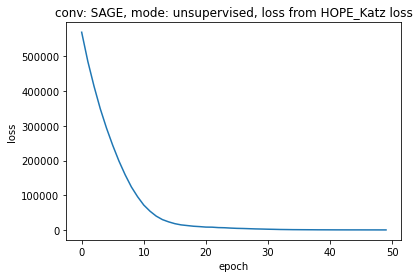

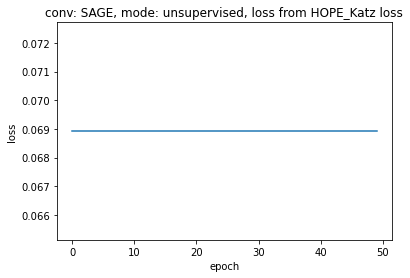

In [9]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
APP ={"Name": "APP","C": "PPR","num_negative_samples":1,"loss var": "Context Matrix","flag_tosave":False,"alpha": 0.9,"Sampler" :SamplerAPP}

loss = HOPE_Katz 
MO = Main('SAGE', device, loss , mode = 'unsupervised')
MO.run()

In [ ]:
device = torch.device('cuda')
MO = MainOptuna('SAGE', device, loss, mode = 'unsupervised',number_of_trials=20)
MO.run(number_of_trials=10)

In [ ]:
device = torch.device('cuda')
MO = MainOptuna('GAT', device, loss, mode = 'unsupervised')
MO.run(number_of_trials=10)